In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import random
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score


In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

number of all smiles:  2050
failed to process smiles:  O=N([O-])C1=C(CN=C1NCCSCc2ncccc2)Cc3ccccc3
failed to process smiles:  c1(nc(NC(N)=[NH2])sc1)CSCCNC(=[NH]C#N)NC
failed to process smiles:  Cc1nc(sc1)\[NH]=C(\N)N
failed to process smiles:  s1cc(CSCCN\C(NC)=[NH]\C#N)nc1\[NH]=C(\N)N
failed to process smiles:  c1c(c(ncc1)CSCCN\C(=[NH]\C#N)NCC)Br
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1ccccc1
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)NC(C)=O
failed to process smiles:  n1c(csc1\[NH]=C(\N)N)c1cccc(c1)N\C(NC)=[NH]\C#N
failed to process smiles:  s1cc(nc1\[NH]=C(\N)N)C
failed to process smiles:  c1(cc(N\C(=[NH]\c2cccc(c2)CC)C)ccc1)CC
number of successfully processed smiles:  2039


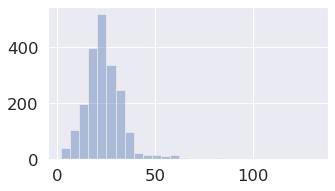

In [4]:
task_name = 'BBBP'
tasks = ['BBBP']
raw_filename = "../data/BBBP.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print("failed to process smiles: ", smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()

# print(len([i for i in atom_num_dist if i<51]),len([i for i in atom_num_dist if i>50]))

In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')
start = time.time()

batch_size = 100
epochs = 800
p_dropout = 0.1
fingerprint_dim = 150

radius = 3
T = 2
weight_decay = 2.9 # also known as l2_regularization_lambda
learning_rate = 3.5
per_task_output_units_num = 2 # for classification model with 2 classes
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
smilesList = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
uncovered = [smiles for smiles in canonical_smiles_list if len(Chem.MolFromSmiles(smiles).GetAtoms())>100]

smiles_tasks_df = smiles_tasks_df[~smiles_tasks_df["cano_smiles"].isin(uncovered)]

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)

remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
remained_df = remained_df.reset_index(drop=True)
uncovered_df

,BBBP,smiles,cano_smiles
944,0,CC(C)C1OC(=O)C2=CCCN2C(=O)c3coc(CC(=O)CC(O)\C=...,C/C1=C/C(O)CC(=O)Cc2nc(co2)C(=O)N2CCC=C2C(=O)O...


In [7]:
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

class ScaffoldGenerator(object):
    """
    Generate molecular scaffolds.

    Parameters
    ----------
    include_chirality : : bool, optional (default False)
      Include chirality in scaffolds.
    """

    def __init__(self, include_chirality=False):
        self.include_chirality = include_chirality

    def get_scaffold(self, mol):
        """
        Get Murcko scaffolds for molecules.

        Murcko scaffolds are described in DOI: 10.1021/jm9602928. They are
        essentially that part of the molecule consisting of rings and the
        linker atoms between them.

        Parameters
        ----------
        mols : array_like
            Molecules.
        """
        return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=self.include_chirality)


def generate_scaffold(smiles, include_chirality=False):
    mol = Chem.MolFromSmiles(smiles)
    engine = ScaffoldGenerator(include_chirality=include_chirality)
    scaffold = engine.get_scaffold(mol)
    return scaffold


In [8]:
weights = []
for i,task in enumerate(tasks):    
    negative_df = remained_df[remained_df[task] == 0][["smiles",task]]
    positive_df = remained_df[remained_df[task] == 1][["smiles",task]]
    weights.append([(positive_df.shape[0]+negative_df.shape[0])/negative_df.shape[0],\
                    (positive_df.shape[0]+negative_df.shape[0])/positive_df.shape[0]])
    
scaffold_list = []
all_scaffolds_dict = {}

for index, smiles in enumerate(remained_df['cano_smiles']):
    scaffold = generate_scaffold(smiles)
    scaffold_list.append(scaffold)
    if scaffold not in all_scaffolds_dict:
        all_scaffolds_dict[scaffold] = [index]
    else:
        all_scaffolds_dict[scaffold].append(index)
remained_df['scaffold'] = scaffold_list


In [9]:
remained_df.groupby(['scaffold'])['scaffold'].count() \
                     .reset_index(name='count') \
                     .sort_values(['count'], ascending=False) \
                     .head(10)

,scaffold,count
991,c1ccccc1,137
0,,99
379,O=C1C=CC2C(=C1)CCC1C3CCCC3CCC21,76
945,c1ccc2c(c1)Nc1ccccc1S2,26
496,O=C1CN=C(c2ccccc2)c2ccccc2N1,26
357,O=C1C=C2CCC3C4CCCC4CCC3C2CC1,24
833,c1ccc(Cc2ccccc2)cc1,21
400,O=C1CC(=O)NC(=O)N1,18
201,O=C(Cc1ccccc1)N1CCNCC1CN1CCCC1,17
994,c1ccncc1,16


In [10]:
def scaffold_randomized_spliting(scaffolds_dict, sample_size, random_seed = 0): 
    count = 0
    minor_count = 0
    minor_class = np.argmax(weights[0]) # weights are inverse of the ratio
    minor_ratio= 1/weights[0][minor_class]
    optimal_count = 0.1*len(remained_df)
    while (count < optimal_count*0.95 or  count > optimal_count*1.05) \
        or (minor_count < minor_ratio*optimal_count*0.95 \
            or  minor_count > minor_ratio*optimal_count*1.05):
        random_seed +=1
        random.seed(random_seed)
        scaffold = random.sample(list(scaffolds_dict.keys()), sample_size)
        count = sum([len(scaffolds_dict[scaffold]) for scaffold in scaffold])
        index = [index for scaffold in scaffold for index in scaffolds_dict[scaffold]]
        minor_count = len(remained_df.iloc[index, :][remained_df[tasks[0]] == minor_class])
#     print(random)
    print(random_seed, count, minor_count, index)
    return scaffold, index

samples_size = int(len(all_scaffolds_dict.keys())*0.1)
print(samples_size)
test_scaffold, test_index = scaffold_randomized_spliting(all_scaffolds_dict, samples_size, random_seed=100)
training_scaffolds_dict = {x: all_scaffolds_dict[x] for x in all_scaffolds_dict.keys() if x not in test_scaffold}
valid_scaffold, valid_index = scaffold_randomized_spliting(training_scaffolds_dict, samples_size, random_seed=100)


102
160 201 49 [176, 836, 1000, 663, 807, 872, 926, 254, 995, 1843, 1158, 689, 1393, 1761, 1025, 977, 1120, 1425, 1712, 1060, 1803, 1588, 331, 1440, 863, 938, 14, 470, 578, 708, 851, 946, 967, 1049, 1155, 1274, 1370, 1606, 1693, 1697, 1703, 1708, 1725, 1741, 1857, 1887, 1917, 476, 1116, 1590, 1998, 169, 633, 1673, 62, 359, 63, 871, 841, 860, 1867, 1004, 734, 909, 492, 1609, 1879, 477, 1565, 1935, 553, 1031, 1264, 1902, 1454, 1327, 304, 23, 1316, 1456, 1208, 1392, 1968, 481, 270, 911, 1436, 1428, 1318, 1801, 106, 283, 284, 216, 222, 822, 916, 572, 1389, 1357, 3, 89, 654, 656, 793, 794, 846, 862, 1154, 1485, 488, 490, 507, 508, 510, 511, 512, 513, 514, 515, 516, 537, 538, 539, 540, 594, 599, 738, 25, 48, 58, 114, 275, 325, 357, 559, 560, 610, 611, 641, 1397, 1398, 1564, 1856, 1384, 1065, 1390, 1500, 27, 1551, 1460, 1157, 1368, 330, 1439, 64, 1690, 1864, 1566, 1209, 1483, 900, 1080, 776, 279, 328, 1032, 1047, 498, 1172, 1657, 1760, 178, 1493, 1236, 1401, 1980, 2003, 1192, 1977, 768, 30, 1

/data2/erikxiong/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [11]:
test_df = remained_df.iloc[test_index,:] # test set
valid_df = remained_df.iloc[valid_index,:] # valid set
train_df = remained_df.drop(test_df.index).drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [12]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([smilesList[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = [nn.CrossEntropyLoss(torch.Tensor(weight),reduction='mean') for weight in weights]
model = Fingerprint(radius, T, num_atom_features,num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()
# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

649206
atom_fc.weight torch.Size([150, 39])
atom_fc.bias torch.Size([150])
neighbor_fc.weight torch.Size([150, 49])
neighbor_fc.bias torch.Size([150])
GRUCell.0.weight_ih torch.Size([450, 150])
GRUCell.0.weight_hh torch.Size([450, 150])
GRUCell.0.bias_ih torch.Size([450])
GRUCell.0.bias_hh torch.Size([450])
GRUCell.1.weight_ih torch.Size([450, 150])
GRUCell.1.weight_hh torch.Size([450, 150])
GRUCell.1.bias_ih torch.Size([450])
GRUCell.1.bias_hh torch.Size([450])
GRUCell.2.weight_ih torch.Size([450, 150])
GRUCell.2.weight_hh torch.Size([450, 150])
GRUCell.2.bias_ih torch.Size([450])
GRUCell.2.bias_hh torch.Size([450])
align.0.weight torch.Size([1, 300])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 300])
align.1.bias torch.Size([1])
align.2.weight torch.Size([1, 300])
align.2.bias torch.Size([1])
attend.0.weight torch.Size([150, 150])
attend.0.bias torch.Size([150])
attend.1.weight torch.Size([150, 150])
attend.1.bias torch.Size([150])
attend.2.weight torch.Size([150, 150])

In [13]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
#         print(torch.Tensor(x_atom).size(),torch.Tensor(x_bonds).size(),torch.cuda.LongTensor(x_atom_index).size(),torch.cuda.LongTensor(x_bond_index).size(),torch.Tensor(x_mask).size())
        
        model.zero_grad()
        # Step 4. Compute your loss function. (Again, Torch wants the target wrapped in a variable)
        loss = 0.0
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where(y_val != -1)[0]
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)

            loss += loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
        # Step 5. Do the backward pass and update the gradient
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    y_val_list = {}
    y_pred_list = {}
    losses_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, test_batch in enumerate(batch_list):
        batch_df = dataset.loc[test_batch,:]
        smiles_list = batch_df.cano_smiles.values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        atom_pred = atoms_prediction.data[:,:,1].unsqueeze(2).cpu().numpy()
        for i,task in enumerate(tasks):
            y_pred = mol_prediction[:, i * per_task_output_units_num:(i + 1) *
                                    per_task_output_units_num]
            y_val = batch_df[task].values

            validInds = np.where((y_val==0) | (y_val==1))[0]
#             validInds = np.where((y_val=='0') | (y_val=='1'))[0]
#             print(validInds)
            if len(validInds) == 0:
                continue
            y_val_adjust = np.array([y_val[v] for v in validInds]).astype(float)
            validInds = torch.cuda.LongTensor(validInds).squeeze()
            y_pred_adjust = torch.index_select(y_pred, 0, validInds)
#             print(validInds)
            loss = loss_function[i](
                y_pred_adjust,
                torch.cuda.LongTensor(y_val_adjust))
#             print(y_pred_adjust)
            y_pred_adjust = F.softmax(y_pred_adjust,dim=-1).data.cpu().numpy()[:,1]
            losses_list.append(loss.cpu().detach().numpy())
            try:
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
            except:
                y_val_list[i] = []
                y_pred_list[i] = []
                y_val_list[i].extend(y_val_adjust)
                y_pred_list[i].extend(y_pred_adjust)
#             print(y_val,y_pred,validInds,y_val_adjust,y_pred_adjust)            
    test_roc = [roc_auc_score(y_val_list[i], y_pred_list[i]) for i in range(len(tasks))]
#     test_prc = [auc(precision_recall_curve(y_val_list[i], y_pred_list[i])[1],precision_recall_curve(y_val_list[i], y_pred_list[i])[0]) for i in range(len(tasks))]
# #     test_prc = auc(recall, precision)
#     test_precision = [precision_score(y_val_list[i],
#                                      (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
#     test_recall = [recall_score(y_val_list[i],
#                                (np.array(y_pred_list[i]) > 0.5).astype(int)) for i in range(len(tasks))]
    test_loss = np.array(losses_list).mean()
    
    return test_roc, test_loss #test_prc, test_precision, test_recall, 


In [14]:
best_param ={}
best_param["roc_epoch"] = 0
best_param["loss_epoch"] = 0
best_param["valid_roc"] = 0
best_param["valid_loss"] = 9e8

for epoch in range(epochs):    
    train_roc, train_loss = eval(model, train_df)
    valid_roc, valid_loss = eval(model, valid_df)
    train_roc_mean = np.array(train_roc).mean()
    valid_roc_mean = np.array(valid_roc).mean()
    
#     tensorboard.add_scalars('ROC',{'train_roc':train_roc_mean,'valid_roc':valid_roc_mean},epoch)
#     tensorboard.add_scalars('Losses',{'train_losses':train_loss,'valid_losses':valid_loss},epoch)

    if valid_roc_mean > best_param["valid_roc"]:
        best_param["roc_epoch"] = epoch
        best_param["valid_roc"] = valid_roc_mean
        if valid_roc_mean > 0.87:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')             
    if valid_loss < best_param["valid_loss"]:
        best_param["loss_epoch"] = epoch
        best_param["valid_loss"] = valid_loss

    print("EPOCH:\t"+str(epoch)+'\n'\
        +"train_roc"+":"+str(train_roc)+'\n'\
        +"valid_roc"+":"+str(valid_roc)+'\n'\
#         +"train_roc_mean"+":"+str(train_roc_mean)+'\n'\
#         +"valid_roc_mean"+":"+str(valid_roc_mean)+'\n'\
        )
    if (epoch - best_param["roc_epoch"] >18) and (epoch - best_param["loss_epoch"] >28):        
        break
        
    train(model, train_df, optimizer, loss_function)


EPOCH:	0
train_roc:[0.6801856763925729]
valid_roc:[0.8266597778351847]

EPOCH:	1
train_roc:[0.758597347480106]
valid_roc:[0.9026091449237923]

EPOCH:	2
train_roc:[0.7745994694960213]
valid_roc:[0.9192715060707827]

EPOCH:	3
train_roc:[0.7814005305039787]
valid_roc:[0.9267631103074141]

EPOCH:	4
train_roc:[0.7906015915119364]
valid_roc:[0.931929733918884]

EPOCH:	5
train_roc:[0.7989262599469497]
valid_roc:[0.9323172306897443]

EPOCH:	6
train_roc:[0.8087045092838197]
valid_roc:[0.933996383363472]

EPOCH:	7
train_roc:[0.8162567639257294]
valid_roc:[0.9368380263497803]

EPOCH:	8
train_roc:[0.8238790450928383]
valid_roc:[0.9355463704469129]

EPOCH:	9
train_roc:[0.8327787798408488]
valid_roc:[0.9387755102040817]

EPOCH:	10
train_roc:[0.8394228116710876]
valid_roc:[0.9387755102040818]

EPOCH:	11
train_roc:[0.8425061007957559]
valid_roc:[0.9394213381555153]

EPOCH:	12
train_roc:[0.8420137931034483]
valid_roc:[0.9373546887109273]

EPOCH:	13
train_roc:[0.8446641909814324]
valid_roc:[0.9392921725

EPOCH:	113
train_roc:[0.9467777188328914]
valid_roc:[0.9492379230173082]

EPOCH:	114
train_roc:[0.9454302387267904]
valid_roc:[0.9466546112115732]

EPOCH:	115
train_roc:[0.944180371352785]
valid_roc:[0.9572461896150866]

EPOCH:	116
train_roc:[0.9464127320954907]
valid_roc:[0.9456212864892792]

EPOCH:	117
train_roc:[0.9466801061007957]
valid_roc:[0.9542753810384914]

EPOCH:	118
train_roc:[0.9469135278514588]
valid_roc:[0.948850426246448]

EPOCH:	119
train_roc:[0.9480551724137931]
valid_roc:[0.9489795918367347]

EPOCH:	120
train_roc:[0.9487618037135278]
valid_roc:[0.9545337122190648]

EPOCH:	121
train_roc:[0.9487448275862069]
valid_roc:[0.9555670369413588]

EPOCH:	122
train_roc:[0.9408509283819629]
valid_roc:[0.953887884267631]

EPOCH:	123
train_roc:[0.9485453580901857]
valid_roc:[0.953371221906484]

EPOCH:	124
train_roc:[0.9463427055702919]
valid_roc:[0.9476879359338671]

EPOCH:	125
train_roc:[0.9483628647214855]
valid_roc:[0.9480754327047275]

EPOCH:	126
train_roc:[0.949795225464191]
v

In [17]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["roc_epoch"])+'.pt')     
# best_model = torch.load('saved_models/model_BBBP_Fri_Jul_26_21-17-57_2019_90.pt')     

# best_model_dict = best_model.state_dict()
# best_model_wts = copy.deepcopy(best_model_dict)

# model.load_state_dict(best_model_wts)
# (best_model.align[0].weight == model.align[0].weight).all()

test_roc, test_losses = eval(best_model, test_df)

print("best epoch:"+str(best_param["roc_epoch"])
      +"\n"+"test_roc:"+str(test_roc)
      +"\n"+"test_roc_mean:",str(np.array(test_roc).mean())
     )

best epoch:115
test_roc:[0.6868958109559614]
test_roc_mean: 0.6868958109559614
